<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/causal_model/notebooks/unified_approach/2_Data_Treatment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 - Removing outliers, understanding the data, visualization of components for each dataset, common period for the different hospitals, data aggregation and transformation of categorical features into numerical ones.

---



---



# Loading libs and database

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m

df_url ="https://raw.githubusercontent.com/douglasmmachado/ExploratoryDataAnalysis/causal_model/datasets/unified_approach/df_unified.csv"


df = pd.read_csv(df_url)



categorical_features = ['ID_REF', 'ID_SITE_RATTACHE', 'CODE_ATC', 'HOSPI_CODE_UCD']
date_features = ['DATE_MOUV', 'WEEK', 'MONTH', 'YEAR']
numerical_features = ['N_UFS', 'QUANTITY', 'N_ETB', 'POPULATION', 'P_MEDICAL', 'PN_MEDICAL', 'LIT_HC', 'LIT_HP', 'SEJ_MCO', 'SEJ_HAD', 'SEJ_PSY', 'SEJ_SSR']

df['DATE_MOUV'] = pd.to_datetime(df['DATE_MOUV'],
              format='%Y-%m-%d')  # Changed the type of date too

for column in categorical_features:
  df[column] = df[column].astype('string')

## 2.1 - Visualisation of data range and data composition

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75684 entries, 0 to 75683
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID_REF            75684 non-null  string        
 1   ID_SITE_RATTACHE  75684 non-null  string        
 2   CODE_ATC          75684 non-null  string        
 3   HOSPI_CODE_UCD    75684 non-null  string        
 4   DATE_MOUV         75684 non-null  datetime64[ns]
 5   N_UFS             75684 non-null  int64         
 6   QUANTITY          75684 non-null  float64       
 7   WEEK              75684 non-null  int64         
 8   MONTH             75684 non-null  int64         
 9   YEAR              75684 non-null  int64         
 10  N_ETB             75684 non-null  int64         
 11  POPULATION        75684 non-null  float64       
 12  P_MEDICAL         75684 non-null  int64         
 13  PN_MEDICAL        75684 non-null  int64         
 14  LIT_HC            7568

In [3]:
def visualize_distribution(df, features):
  '''
    Plot of distribution for the numerical features after removing the outliers
  '''

  fig, axes = plt.subplots(4, 3,sharex=False, figsize=(20,20))

  i = 0
  j = 0
  for column in features:
    sns.histplot(df[column], kde=True, stat="density", kde_kws=dict(cut=3),alpha=.4, edgecolor=(1, 1, 1, .4),ax=axes[i, j]).set(title='Distribution of: ' + str(column))
    if j == 2:
      i += 1
      j = 0
    else:
      j+=1

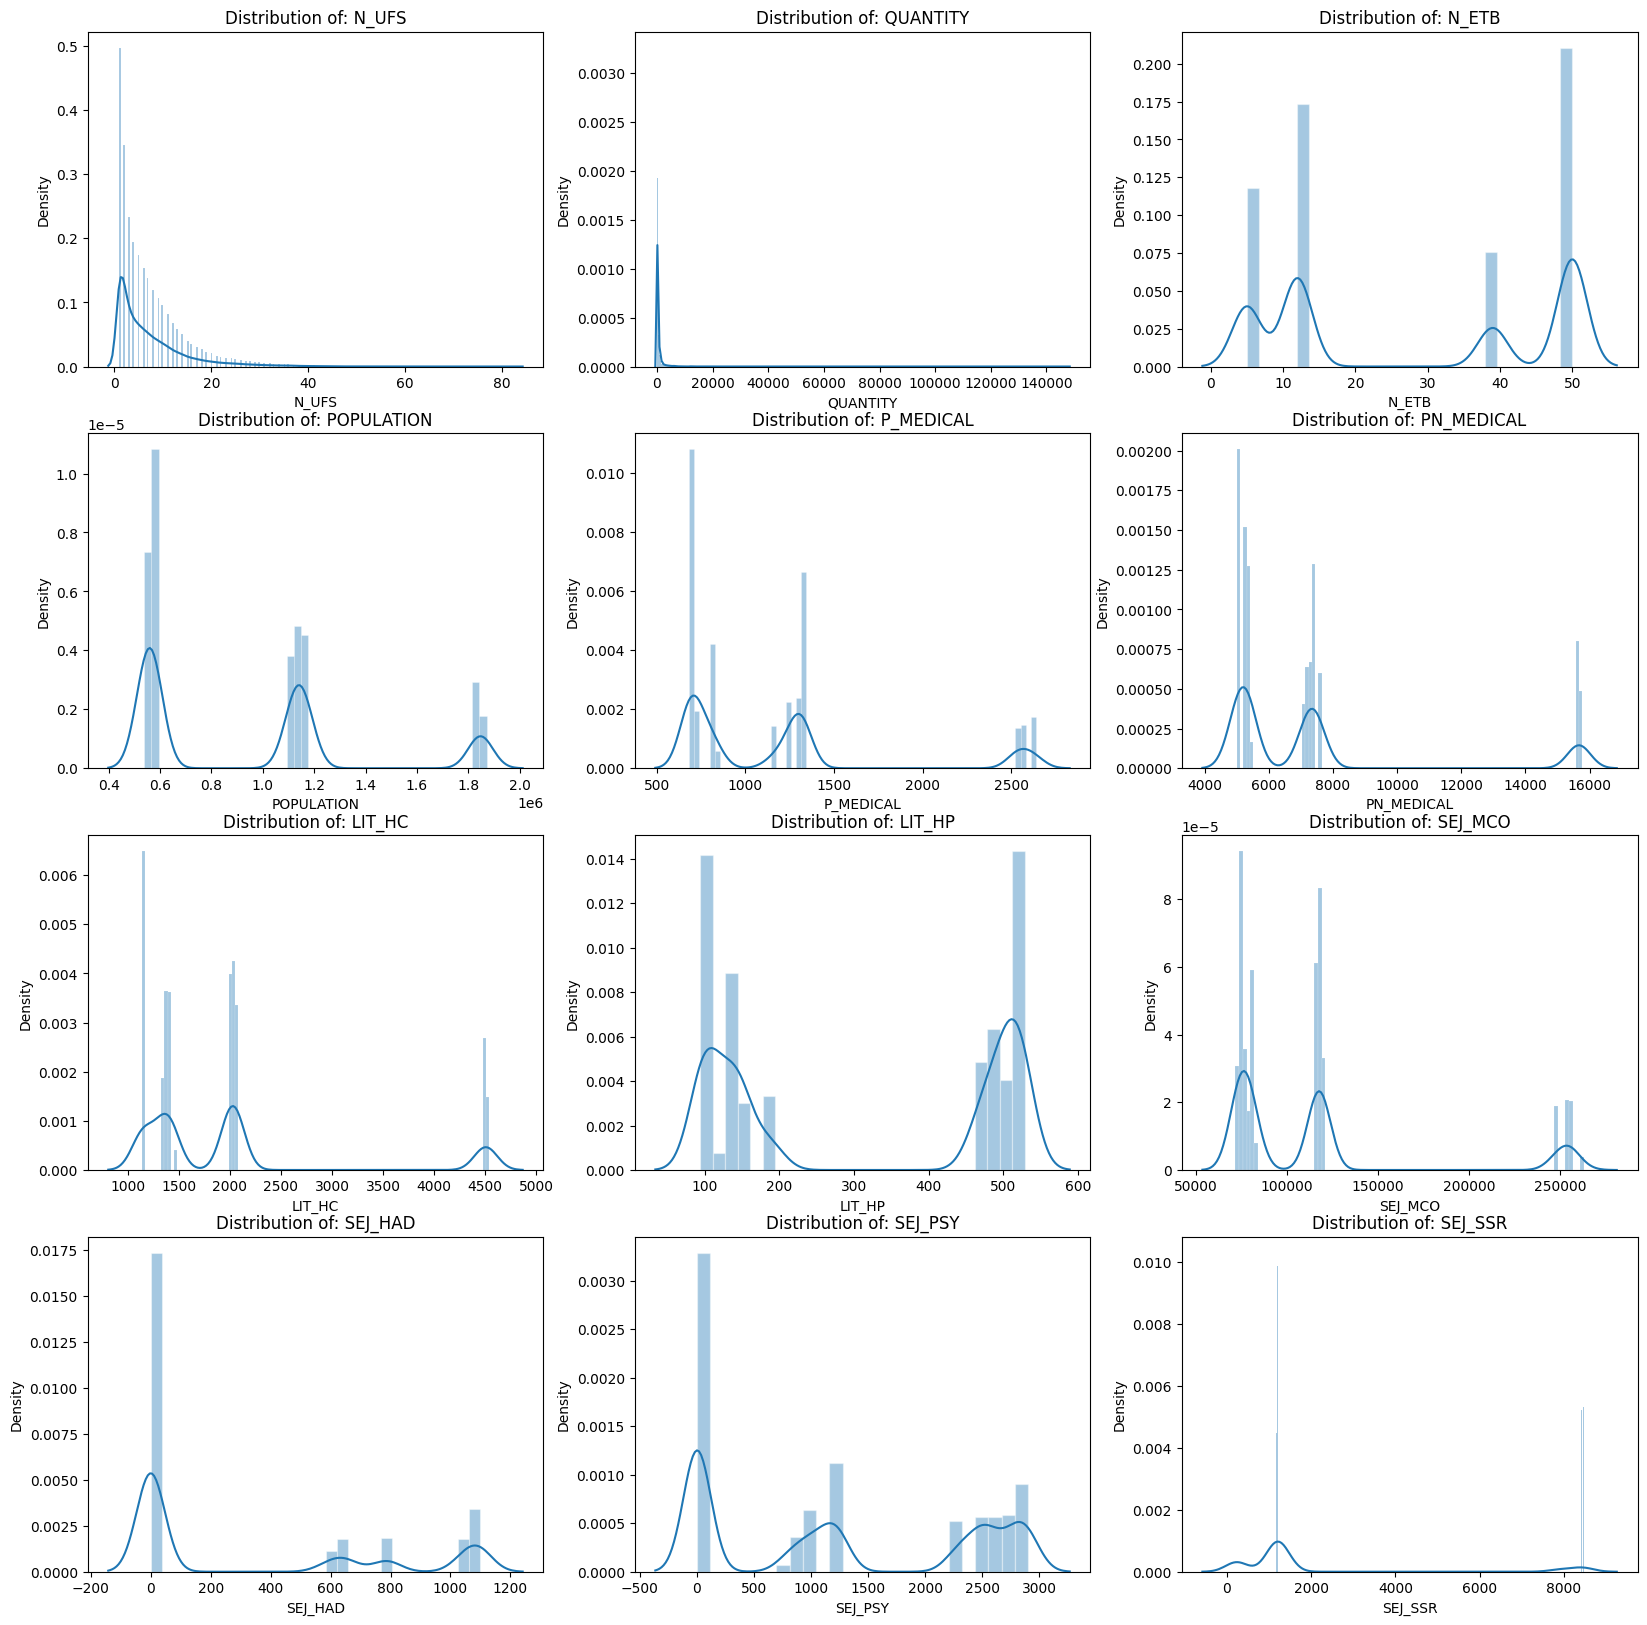

In [4]:
visualize_distribution(df, numerical_features)

## 2.2 - Removing outliers by hospital and by drug

In [6]:
def remove_outliers(df, columns, verbose=False):
    N_macro = df.shape[0]
    new_df = pd.DataFrame()  # Create an empty DataFrame to store the filtered values
    removed_outliers = 0  # Variable to keep track of the total number of removed outliers

    for col in columns:
        for ucd_code in df['HOSPI_CODE_UCD'].unique():
            # Filter the dataframe for the specific HOSPI_CODE_UCD
            df_subset = df[df['HOSPI_CODE_UCD'] == ucd_code]
            N = df_subset.shape[0]

            # Calculate the statistics for the column within the HOSPI_CODE_UCD subset
            q25, q75 = np.percentile(df_subset[col], [25, 75])
            iqr = q75 - q25
            lower, upper = q25 - (iqr * 1.5), q75 + (iqr * 1.5)

            # Remove outliers based on the cutoff values within the HOSPI_CODE_UCD subset
            df_filtered = df_subset[(df_subset[col] >= lower) & (df_subset[col] <= upper)]
            N_new = df_filtered.shape[0]
            delta = N - N_new

            # Update the new DataFrame with the filtered values
            new_df = pd.concat([new_df, df_filtered])

            if verbose:
                if delta > 0:
                    print(f'Column: {col}')
                    print(f'HOSPI_CODE_UCD: {ucd_code}')
                    print(f'Removed outliers: {delta}')
                    print(f'Removed percentage: {(100 * delta / N):.3}%')
                    print()

            removed_outliers += delta

    new_df.reset_index(drop=True, inplace=True)
    print('N_old:', N_macro)
    N_macro_new = new_df.shape[0]
    print('N_new:', N_macro_new)
    delta = N_macro - N_macro_new
    print(f'Total removed outliers: {(100 * delta / N_macro):.3}%')

    return new_df


In [26]:
print("-"*100)
df_wo_outliers = pd.concat([remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_1'], ["QUANTITY"], verbose = False),
                                remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_2'], ["QUANTITY"], verbose = False),
                                remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_3'], ["QUANTITY"], verbose = False),
                                remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_4'], ["QUANTITY"], verbose = False)])


----------------------------------------------------------------------------------------------------
N_old: 22725
N_new: 21715
Total removed outliers: 4.44%
N_old: 15439
N_new: 14953
Total removed outliers: 3.15%
N_old: 27591
N_new: 26801
Total removed outliers: 2.86%
N_old: 9929
N_new: 9638
Total removed outliers: 2.93%


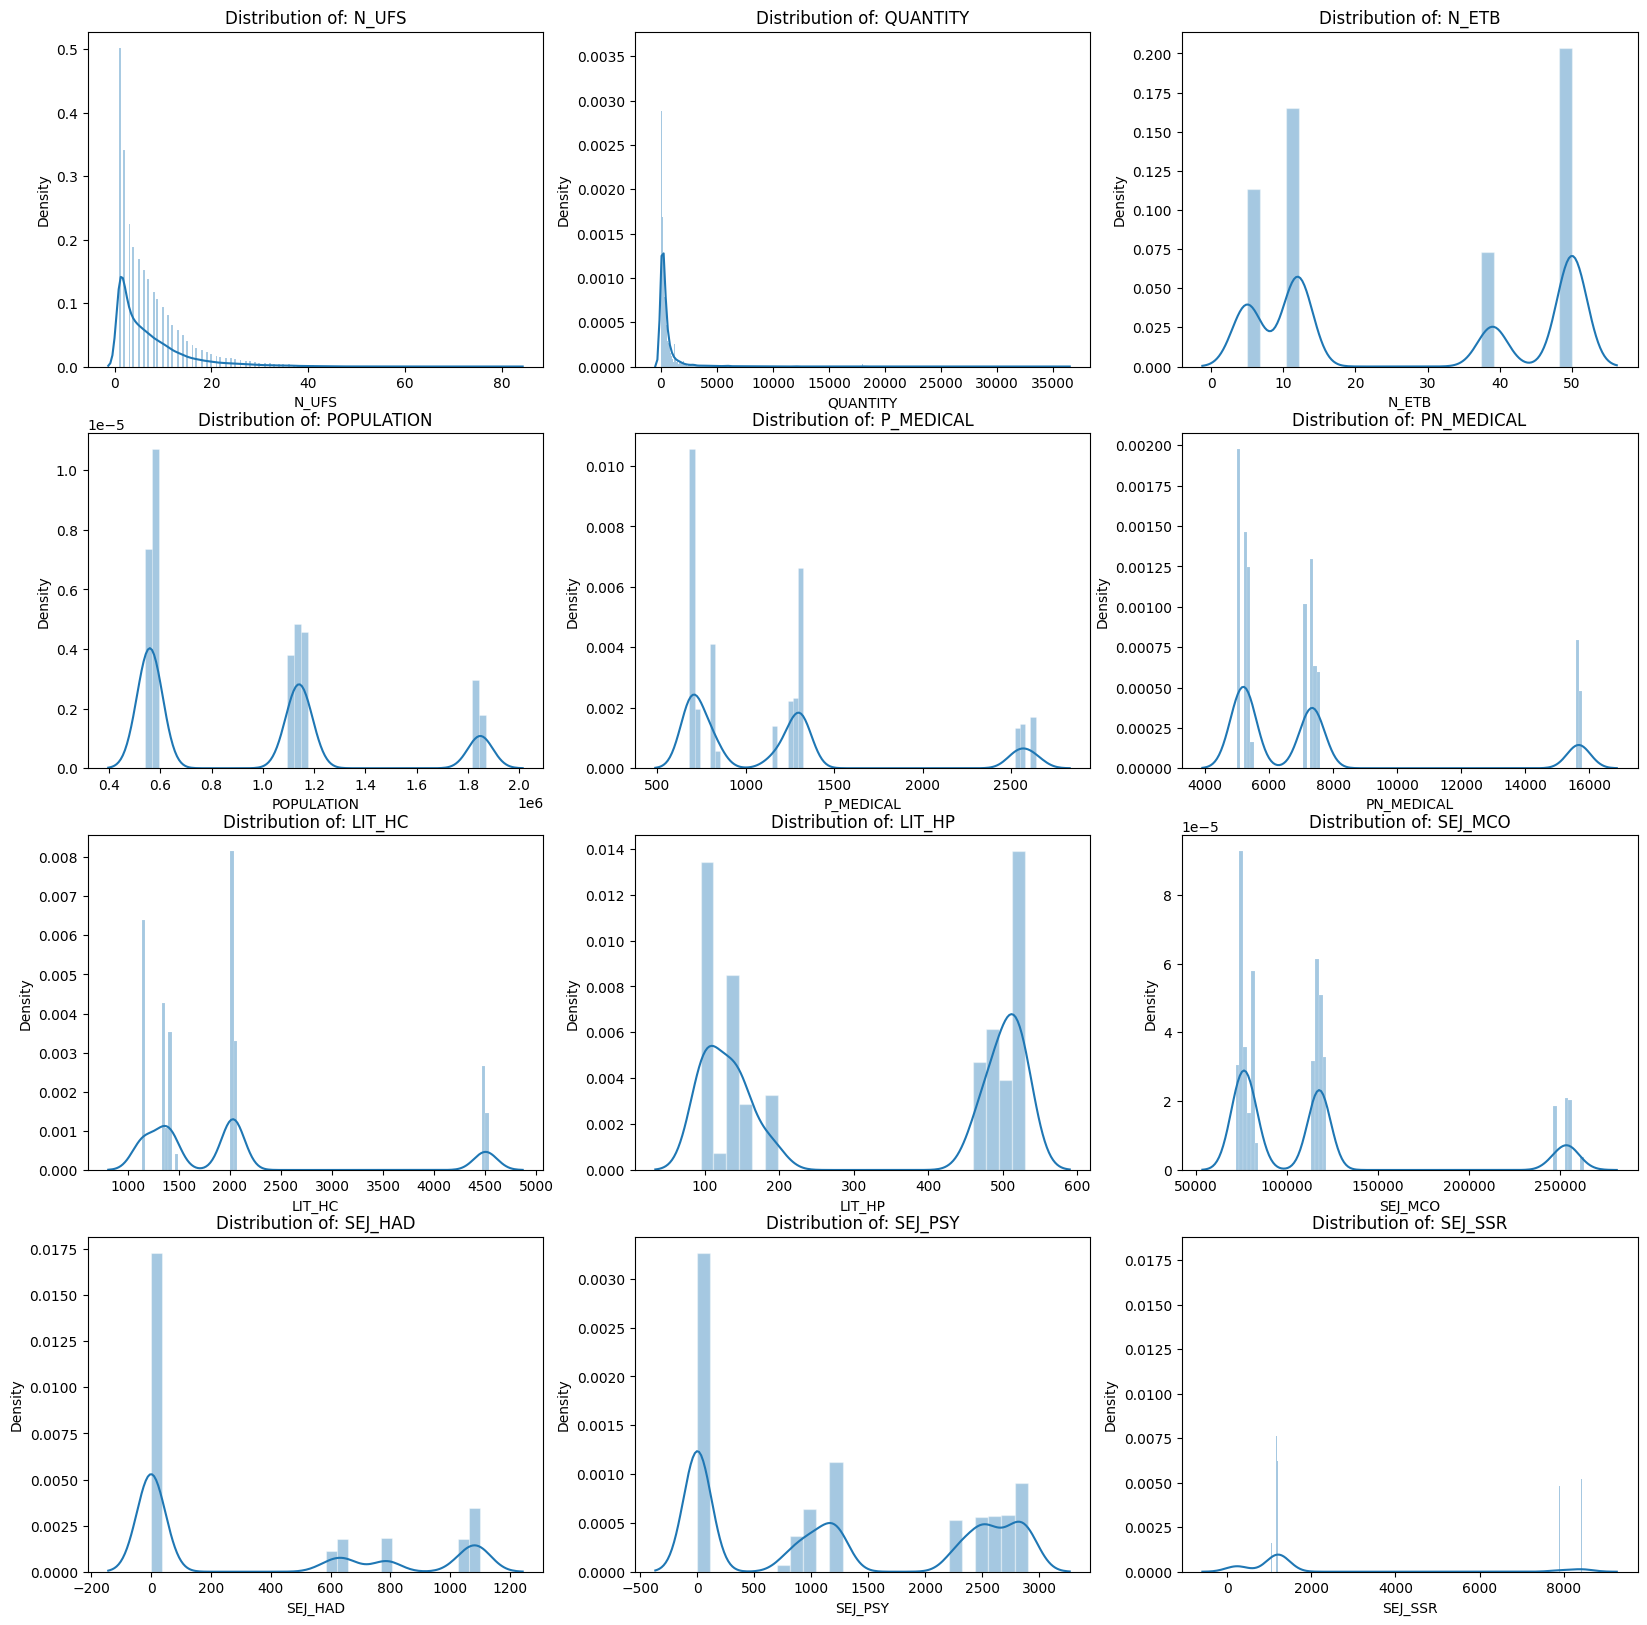

In [ ]:
visualize_distribution(df_wo_outliers, numerical_features)

In [27]:
for column in categorical_features:
  df[column] = df[column].astype('string')

## 2.3 - Define common period for data usage

## 2.4 - Fill gaps in data for eache medicine and for each hospital

## 2.5 - Aggregate data by drug, hospital, year and month

In [10]:
def aggregate_dataframe(df):

    for column in categorical_features: #Transform categorical features
      df[column] = df[column].astype('string')

    df['DATE'] = df['DATE_MOUV'].dt.strftime('%Y-%m')
    df.drop('DATE_MOUV', axis=1, inplace=True)

    df = df.groupby(["ID_SITE_RATTACHE", "HOSPI_CODE_UCD", "YEAR", "MONTH"], as_index=False).agg({
        'QUANTITY': np.sum,
        'CODE_ATC': 'first',
        'N_UFS': np.median,
        'DATE':'first',
        'WEEK': 'first',
        'N_ETB': np.median,
        'POPULATION': np.median,
        'P_MEDICAL': np.median,
        'PN_MEDICAL': np.median,
        'LIT_HC': np.median,
        'LIT_HP': np.median,
        'SEJ_MCO': np.median,
        'SEJ_HAD': np.median,
        'SEJ_PSY': np.median,
        'SEJ_SSR': np.median,
        'SEJ_SLD': np.median
    })

    df.sort_values(by=['DATE', 'HOSPI_CODE_UCD', 'ID_SITE_RATTACHE'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [28]:
# Grouping the different datasets divided by hospital

df_aggregated = aggregate_dataframe(df.copy())

In [33]:
df_aggregated

,ID_SITE_RATTACHE,HOSPI_CODE_UCD,YEAR,MONTH,QUANTITY,CODE_ATC,N_UFS,DATE,WEEK,N_ETB,POPULATION,P_MEDICAL,PN_MEDICAL,LIT_HC,LIT_HP,SEJ_MCO,SEJ_HAD,SEJ_PSY,SEJ_SSR,SEJ_SLD
0,HOSPI_1,3400891191226,2013,6,10.0,N05CF01,1.0,2013-06,25,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0
1,HOSPI_1,3400891225037,2013,6,20.0,A12BA01,1.0,2013-06,25,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0
2,HOSPI_1,3400891996128,2013,6,110.0,N02BE01,1.0,2013-06,25,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0
3,HOSPI_1,3400892065366,2013,6,30.0,B01AC06,1.0,2013-06,25,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0
4,HOSPI_1,3400892075761,2013,6,20.0,N05BA12,1.0,2013-06,25,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4069,HOSPI_3,3400893736135,2019,12,4750.0,A03AX12,6.0,2019-12,49,50.0,1171739.0,1318.0,7578.0,2011.0,529.0,116793.0,1099.0,2297.0,1169.0,124.0
4070,HOSPI_2,3400893826706,2019,12,2121.0,B05XA09,6.0,2019-12,49,5.0,542302.0,706.0,5013.0,1141.0,141.0,76593.0,0.0,1007.0,206.0,0.0
4071,HOSPI_3,3400893826706,2019,12,9070.0,B05XA09,7.5,2019-12,49,50.0,1171739.0,1318.0,7578.0,2011.0,529.0,116793.0,1099.0,2297.0,1169.0,124.0
4072,HOSPI_2,3400893875490,2019,12,7920.0,N02BE01,12.0,2019-12,48,5.0,542302.0,706.0,5013.0,1141.0,141.0,76593.0,0.0,1007.0,206.0,0.0


## 2.6 - Visualize period and replace outliers with median

In [46]:
def replace_numerical_outliers(df, column_name):
  for medicine in df.HOSPI_CODE_UCD.unique():
      subset = df[df['HOSPI_CODE_UCD'] == medicine]
      q1 = subset[column_name].quantile(0.25)
      q3 = subset[column_name].quantile(0.75)
      iqr = q3 - q1
      lower_bound = q1 - 1.5 * iqr

      upper_bound = q3 + 1.5 * iqr
      outliers = (subset[column_name] < lower_bound) | (subset[column_name] > upper_bound)
      subset.loc[outliers, column_name] = subset[column_name].median()
      df.update(subset)

In [56]:
df_resampled = df_aggregated.copy()
replace_numerical_outliers(df_resampled, 'QUANTITY')

mapping = {'HOSPI_1': 1, 'HOSPI_2': 2, 'HOSPI_3': 3, 'HOSPI_4': 4}
df_resampled['ID_SITE_RATTACHE'] = df_resampled['ID_SITE_RATTACHE'].map(mapping)

df_resampled

,ID_SITE_RATTACHE,HOSPI_CODE_UCD,YEAR,MONTH,QUANTITY,CODE_ATC,N_UFS,DATE,WEEK,N_ETB,POPULATION,P_MEDICAL,PN_MEDICAL,LIT_HC,LIT_HP,SEJ_MCO,SEJ_HAD,SEJ_PSY,SEJ_SSR,SEJ_SLD
0,1,3400891191226,2013.0,6.0,10.0,N05CF01,1.0,2013-06,25.0,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0
1,1,3400891225037,2013.0,6.0,20.0,A12BA01,1.0,2013-06,25.0,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0
2,1,3400891996128,2013.0,6.0,110.0,N02BE01,1.0,2013-06,25.0,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0
3,1,3400892065366,2013.0,6.0,30.0,B01AC06,1.0,2013-06,25.0,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0
4,1,3400892075761,2013.0,6.0,2955.0,N05BA12,1.0,2013-06,25.0,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4069,3,3400893736135,2019.0,12.0,4750.0,A03AX12,6.0,2019-12,49.0,50.0,1171739.0,1318.0,7578.0,2011.0,529.0,116793.0,1099.0,2297.0,1169.0,124.0
4070,2,3400893826706,2019.0,12.0,2121.0,B05XA09,6.0,2019-12,49.0,5.0,542302.0,706.0,5013.0,1141.0,141.0,76593.0,0.0,1007.0,206.0,0.0
4071,3,3400893826706,2019.0,12.0,9070.0,B05XA09,7.5,2019-12,49.0,50.0,1171739.0,1318.0,7578.0,2011.0,529.0,116793.0,1099.0,2297.0,1169.0,124.0
4072,2,3400893875490,2019.0,12.0,7920.0,N02BE01,12.0,2019-12,48.0,5.0,542302.0,706.0,5013.0,1141.0,141.0,76593.0,0.0,1007.0,206.0,0.0


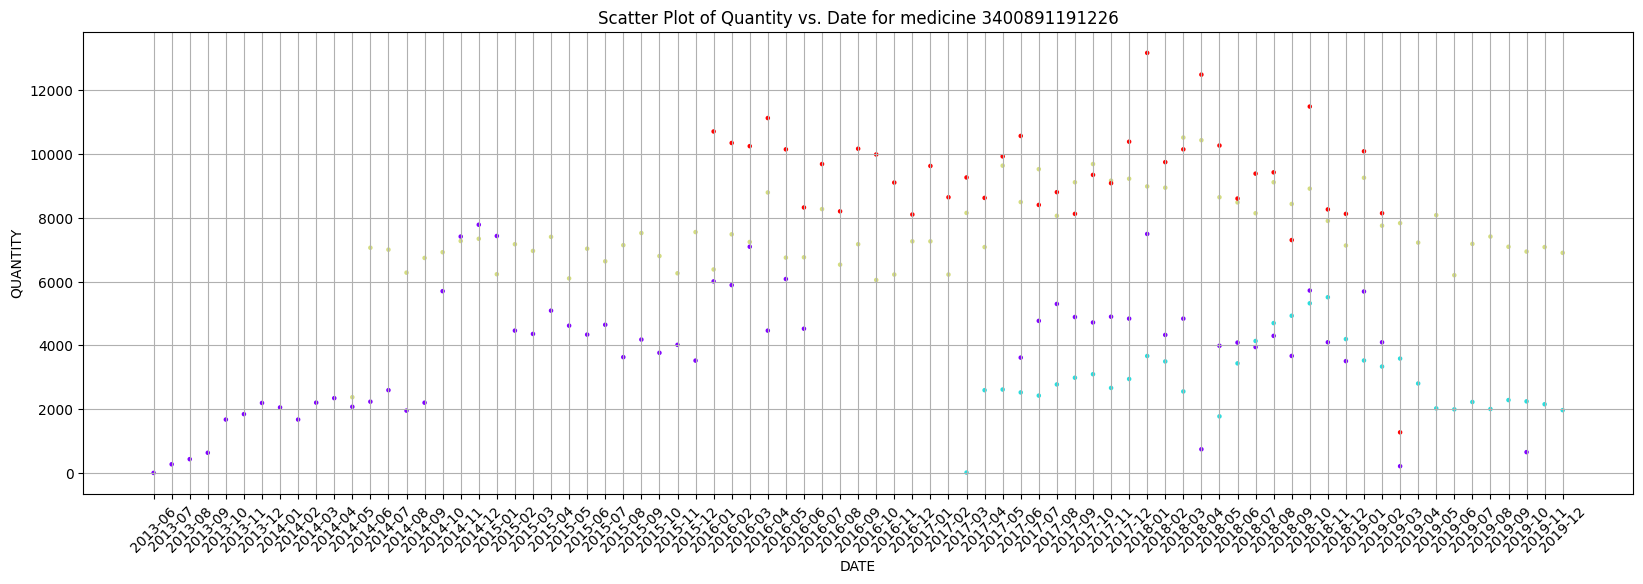

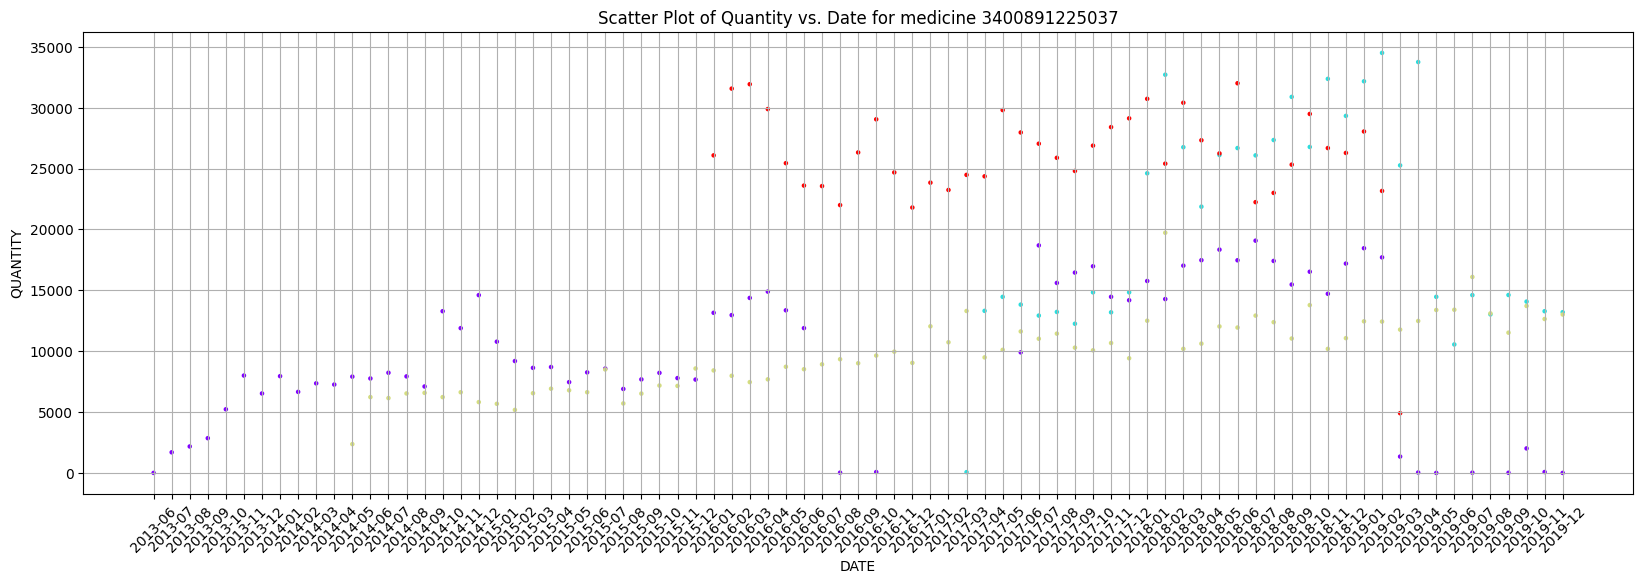

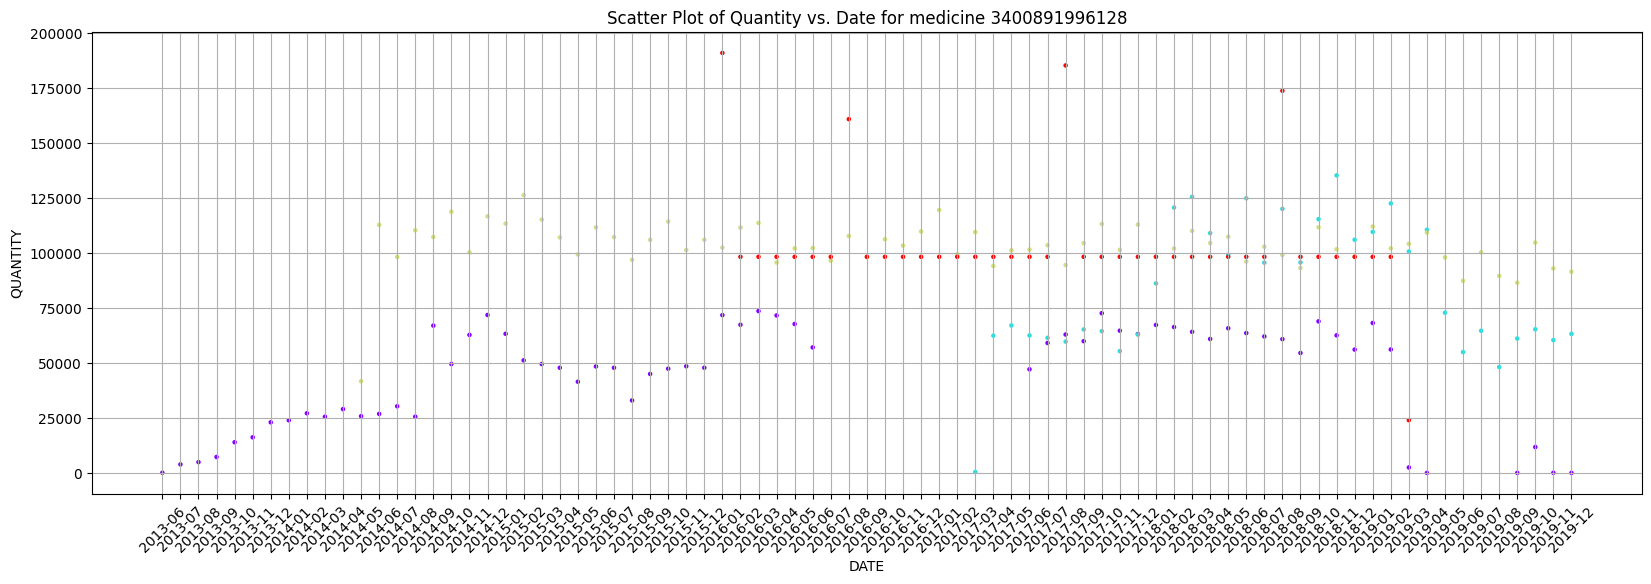

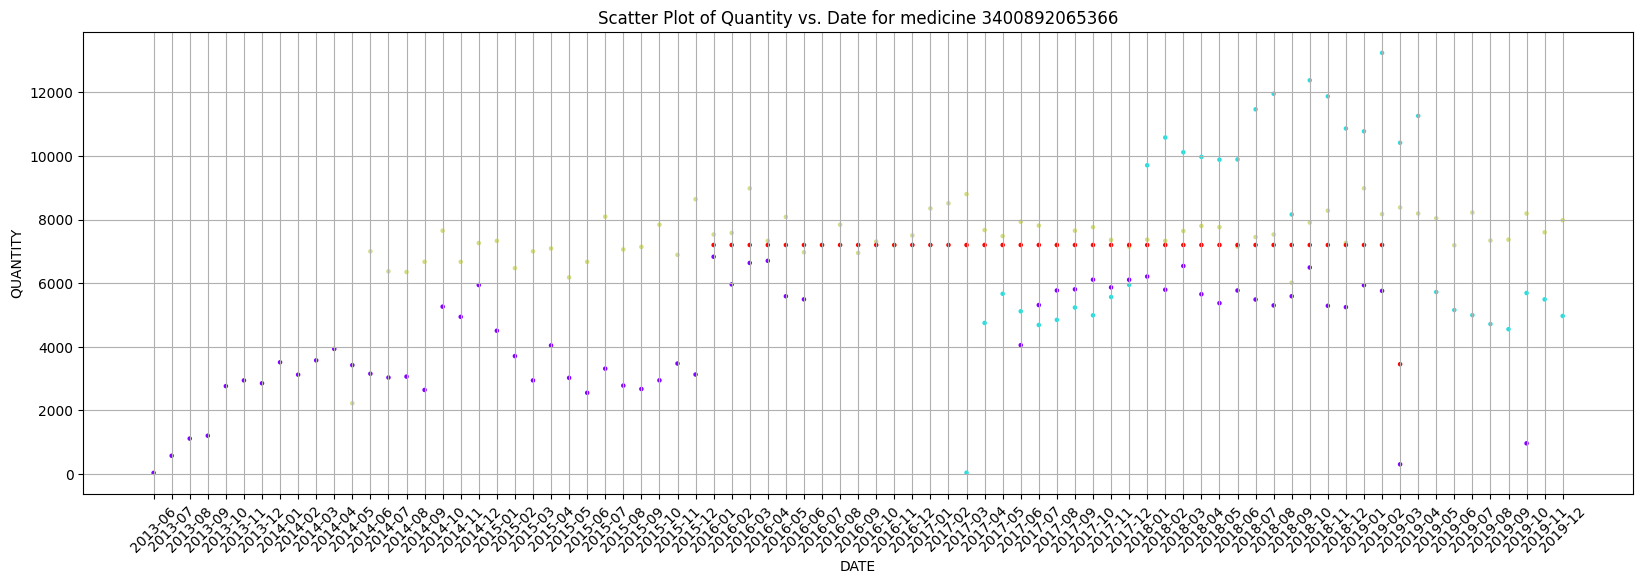

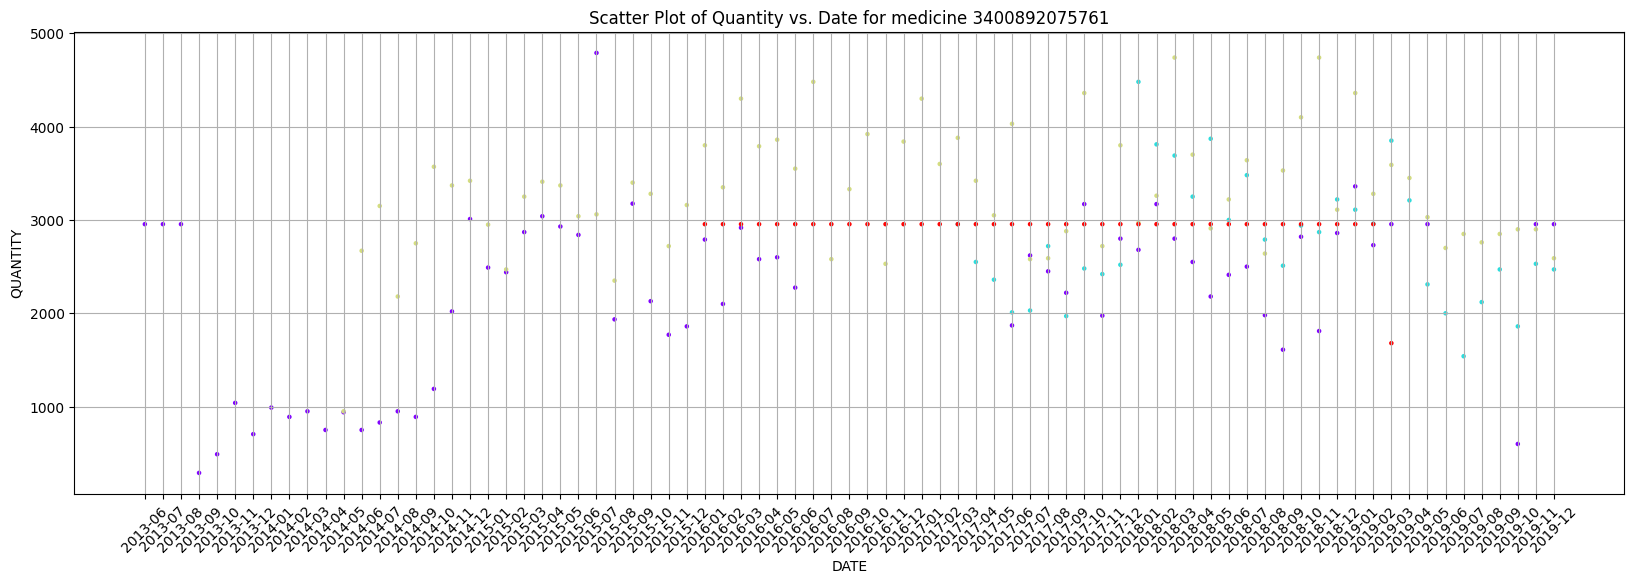

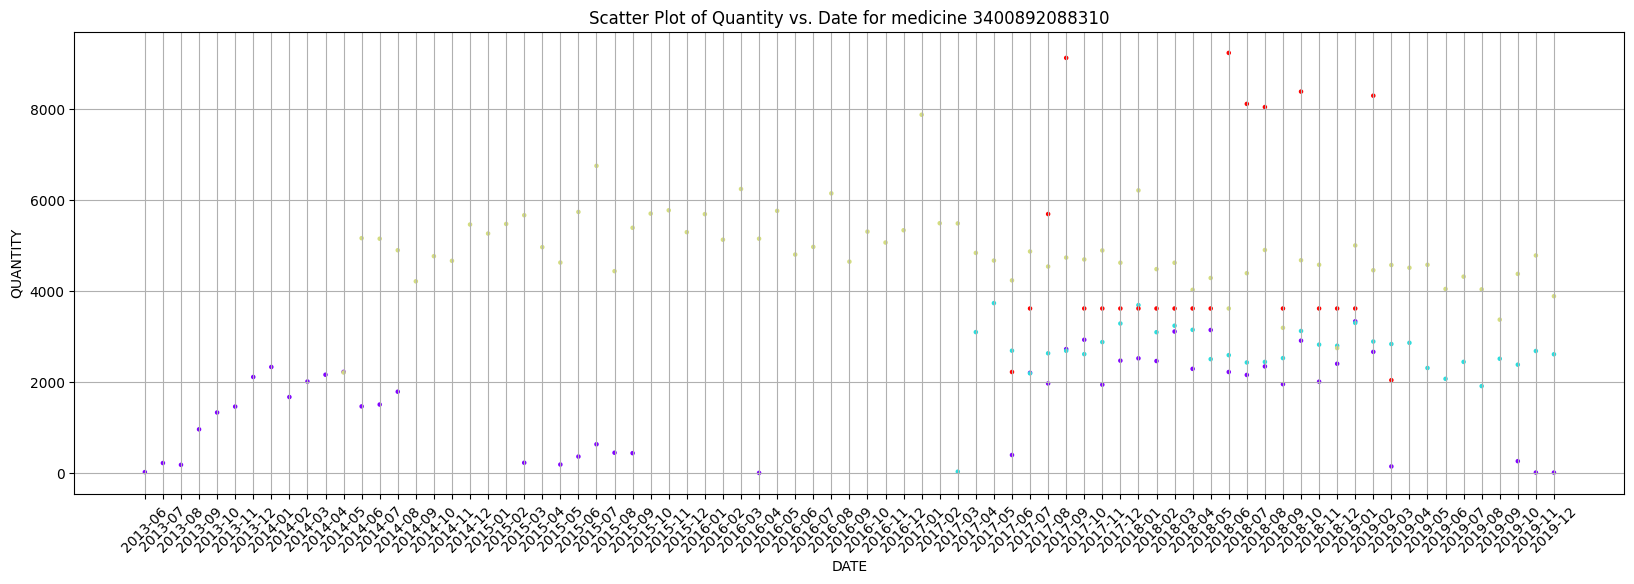

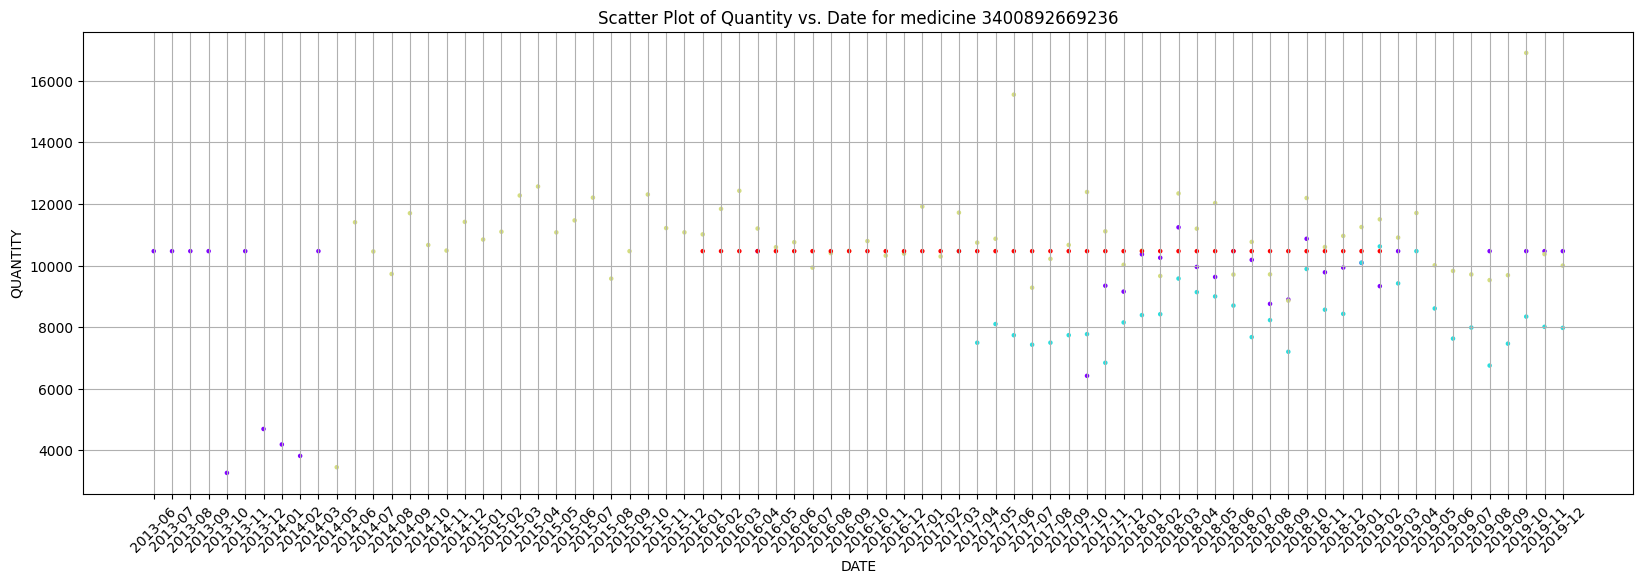

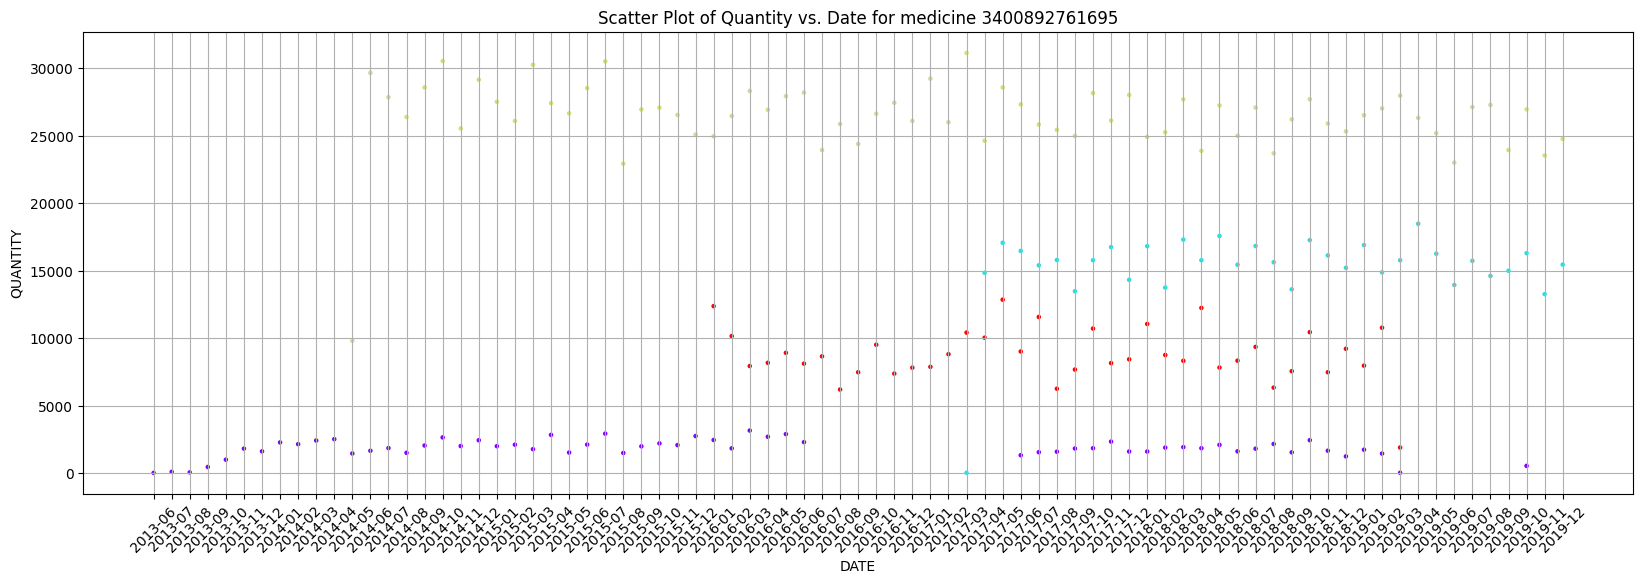

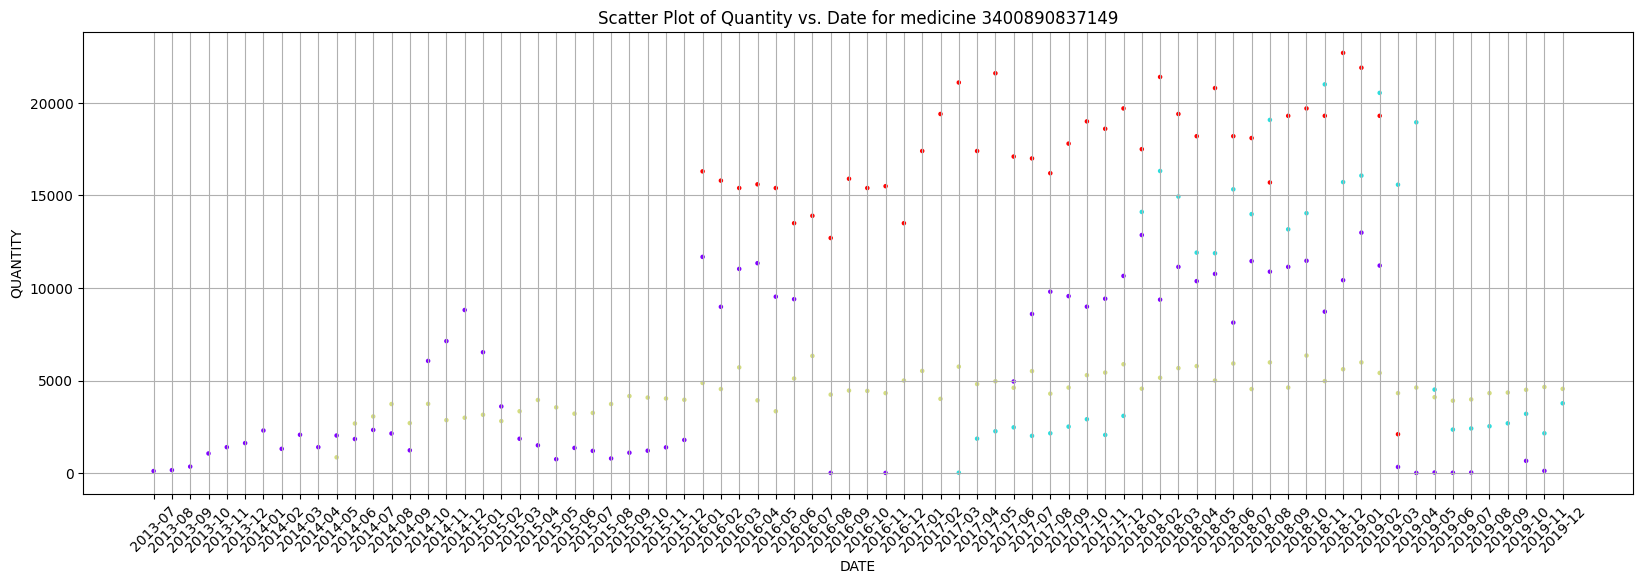

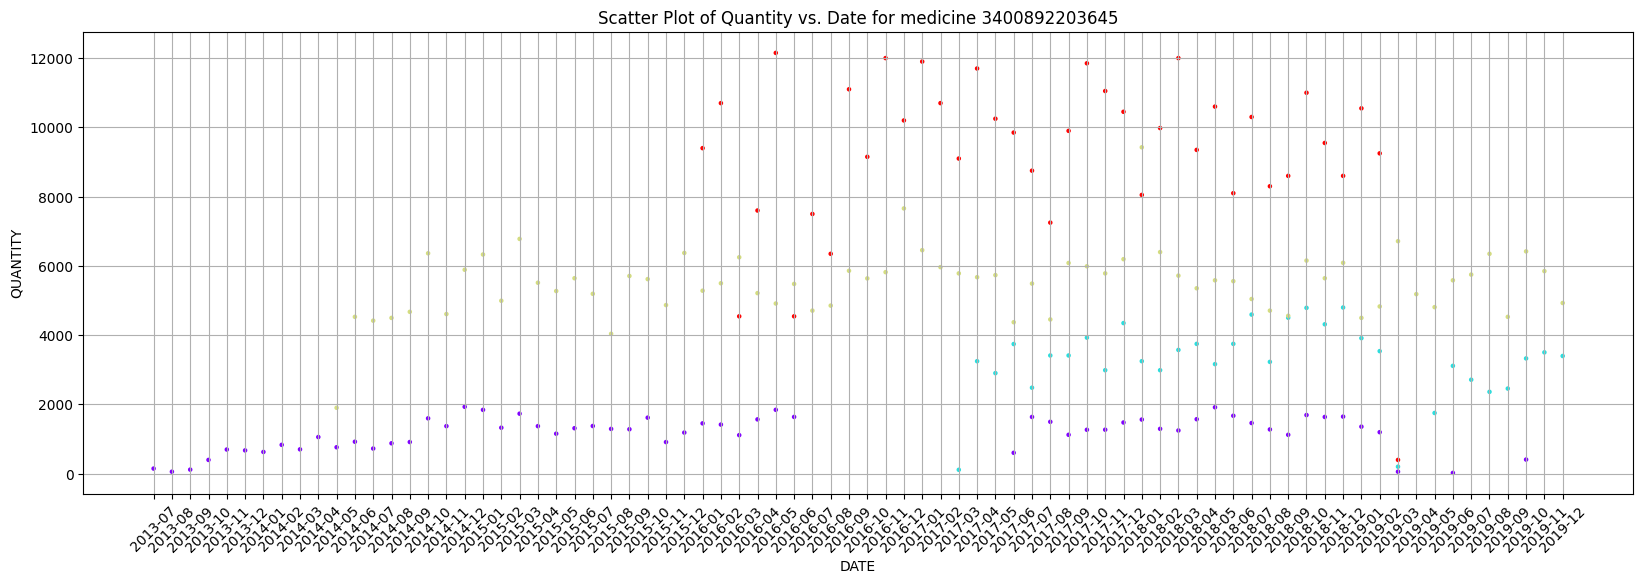

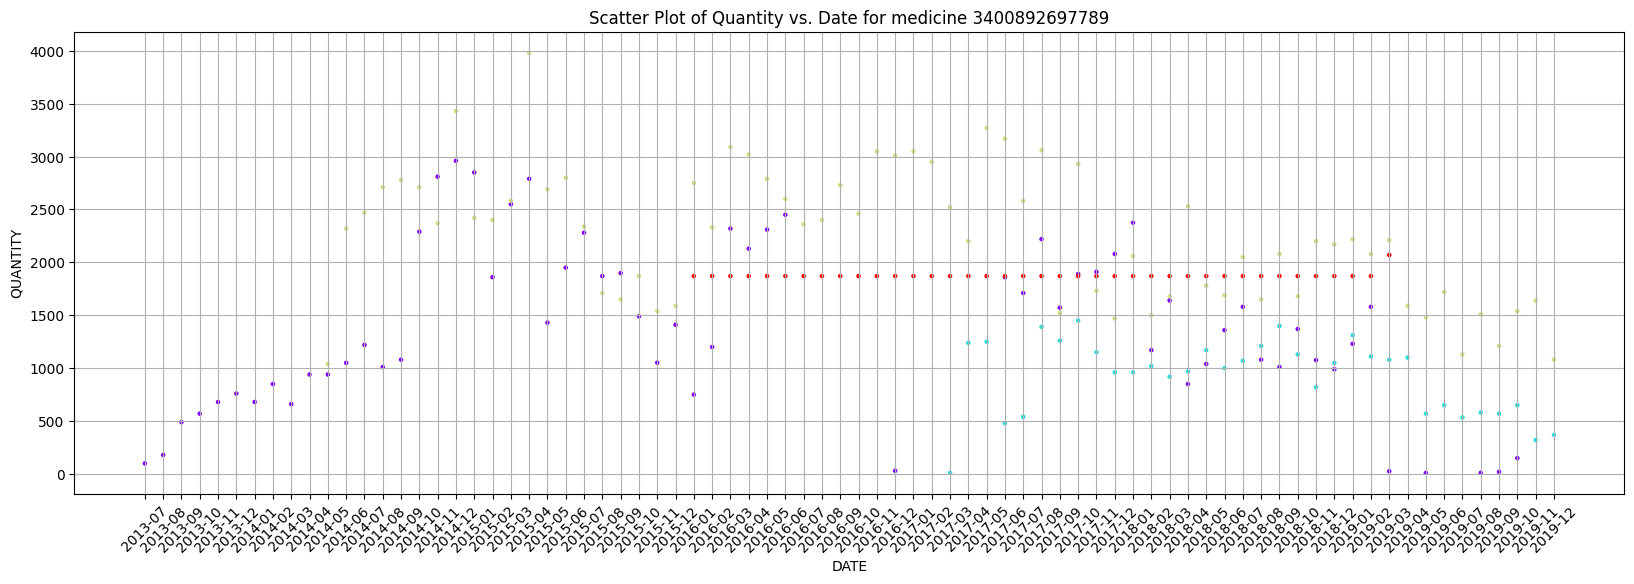

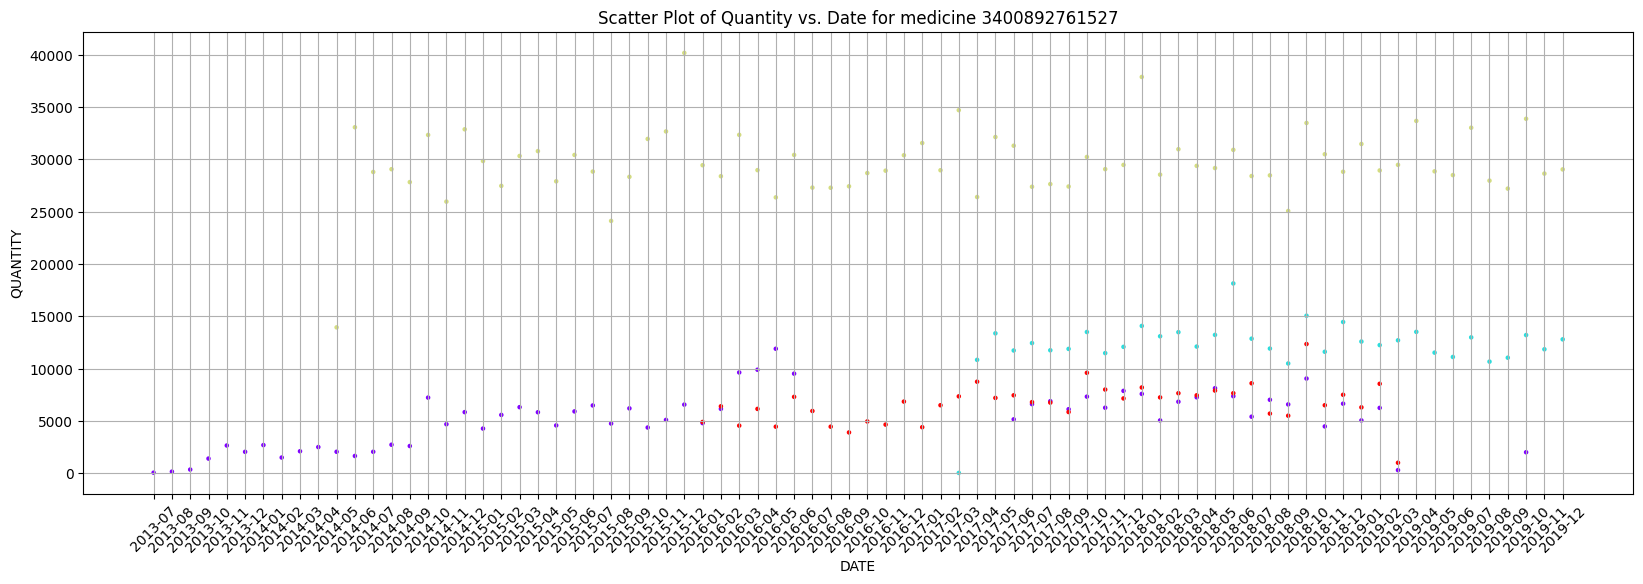

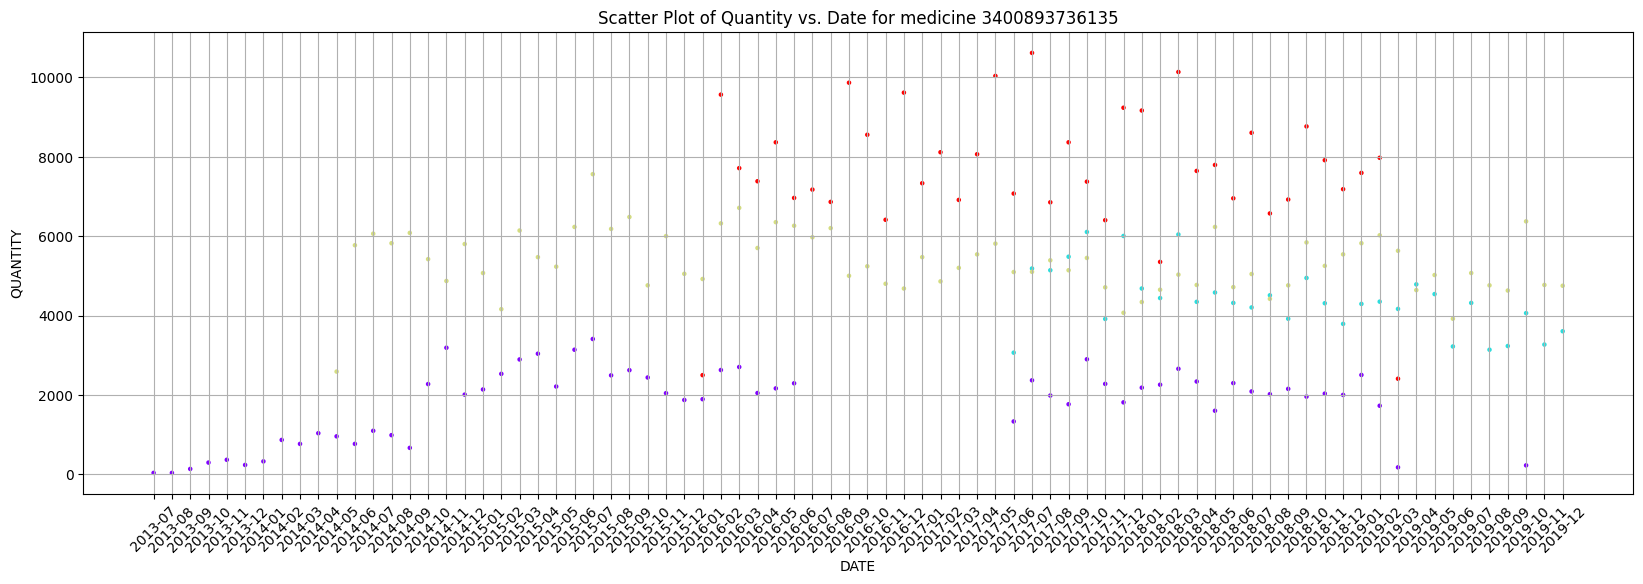

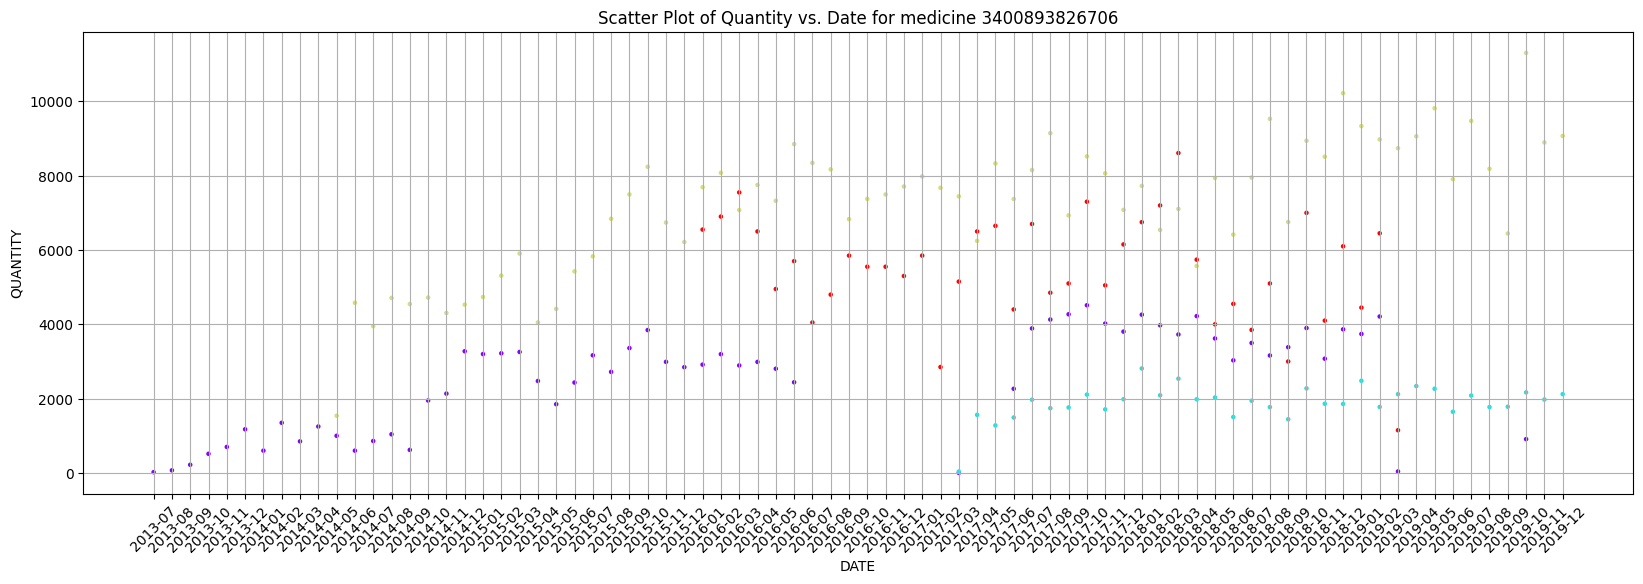

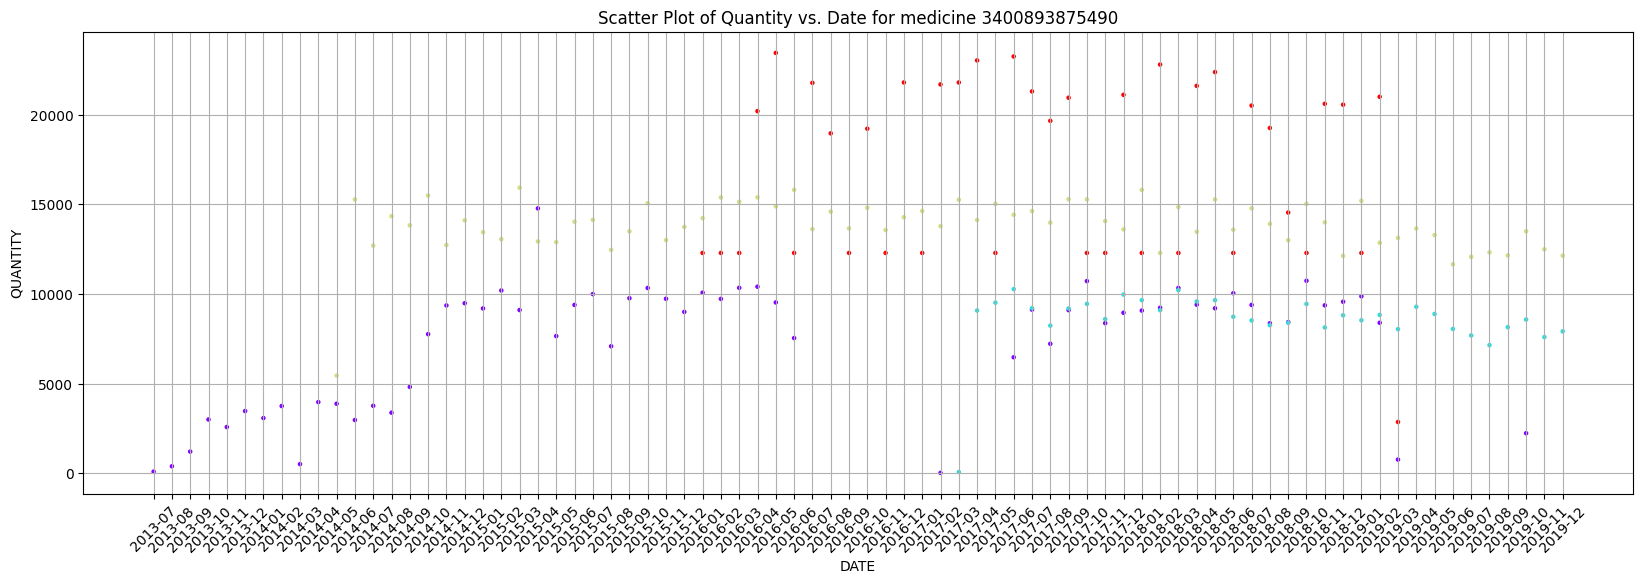

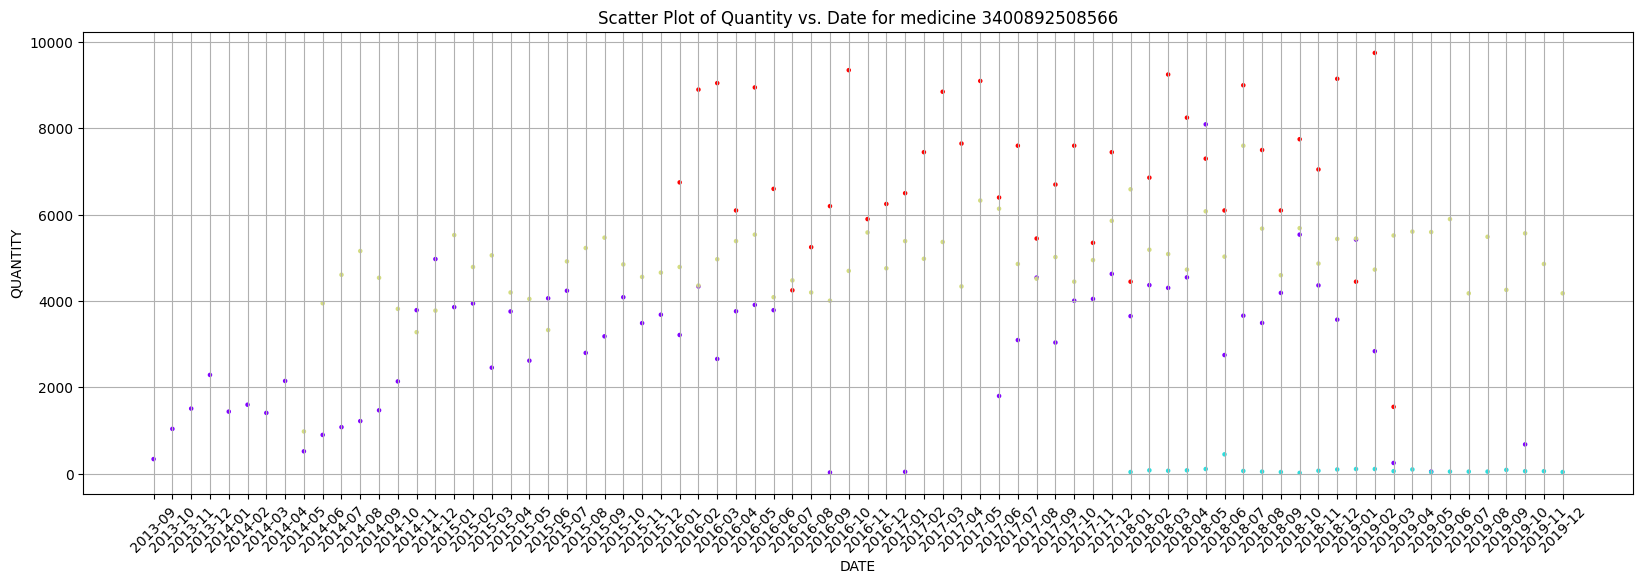

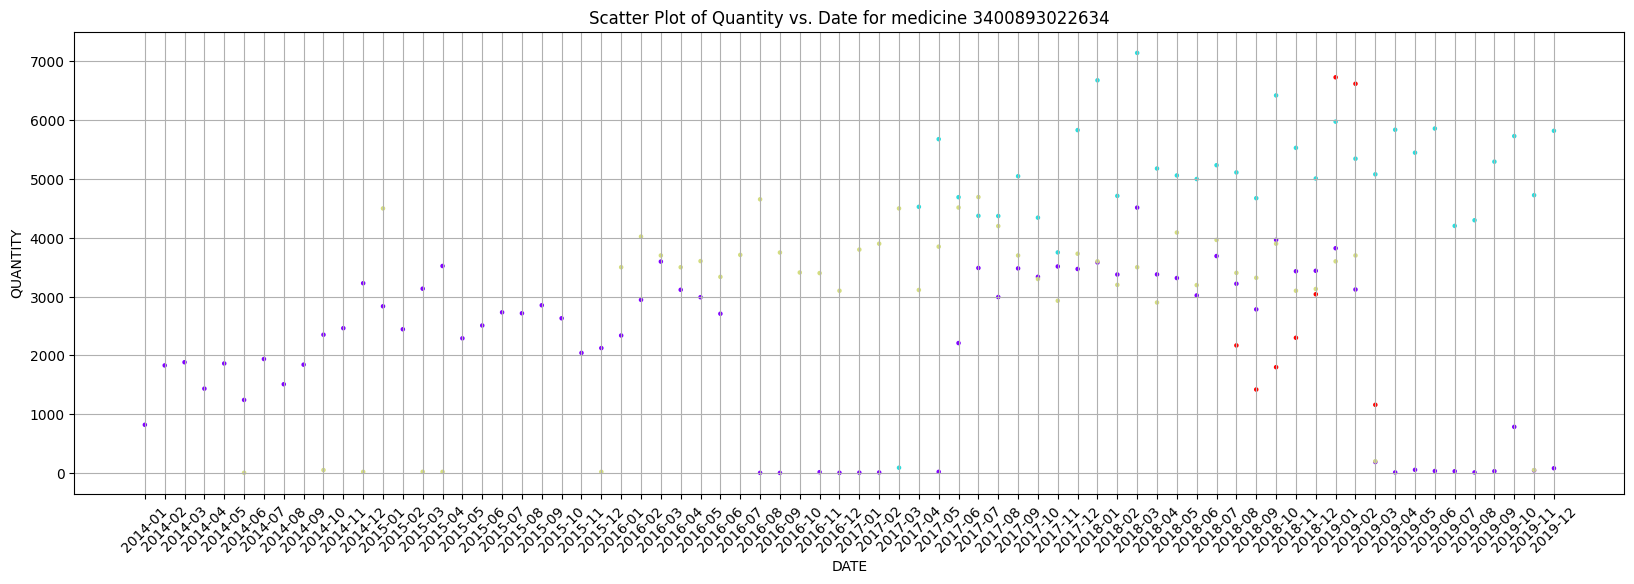

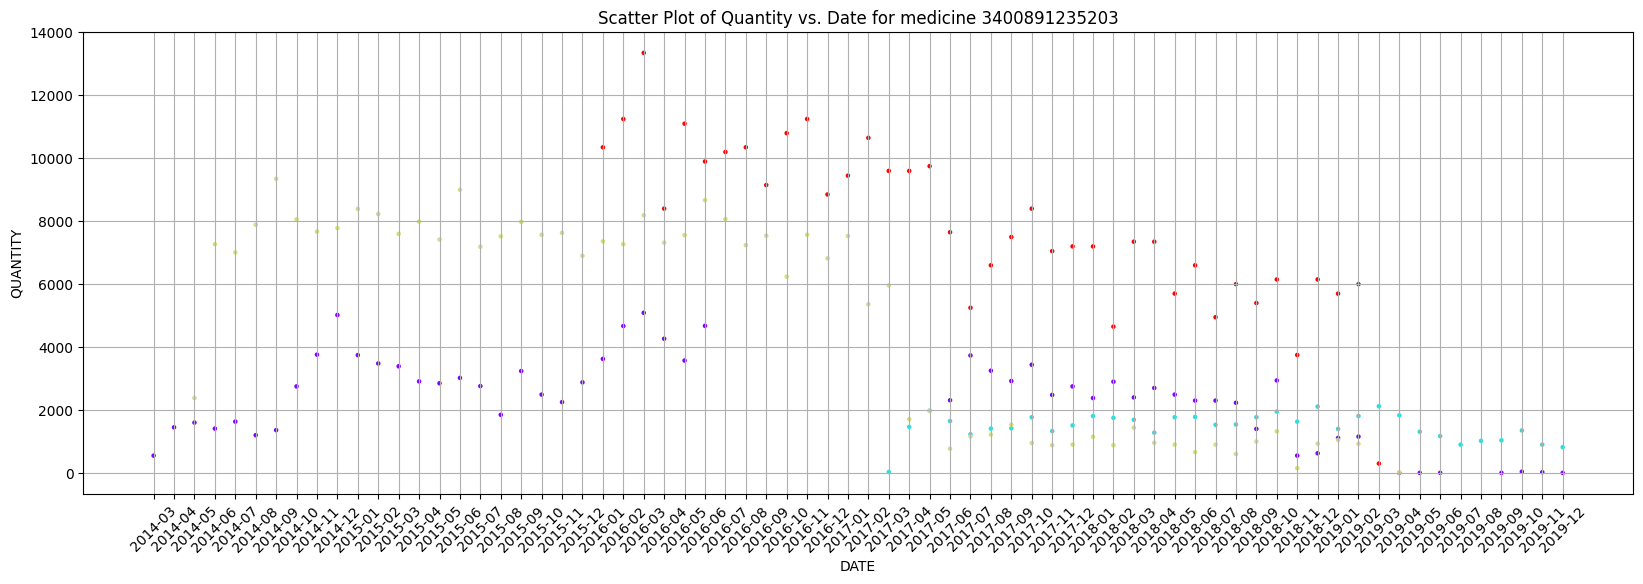

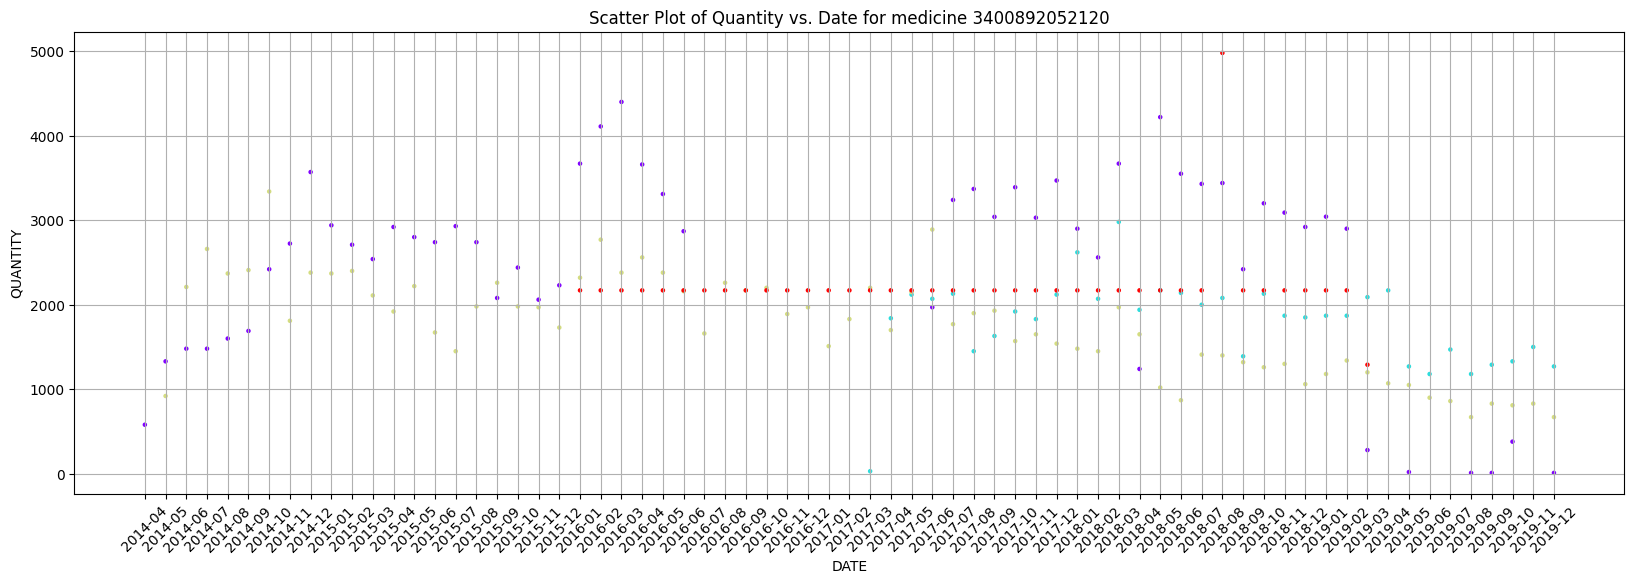

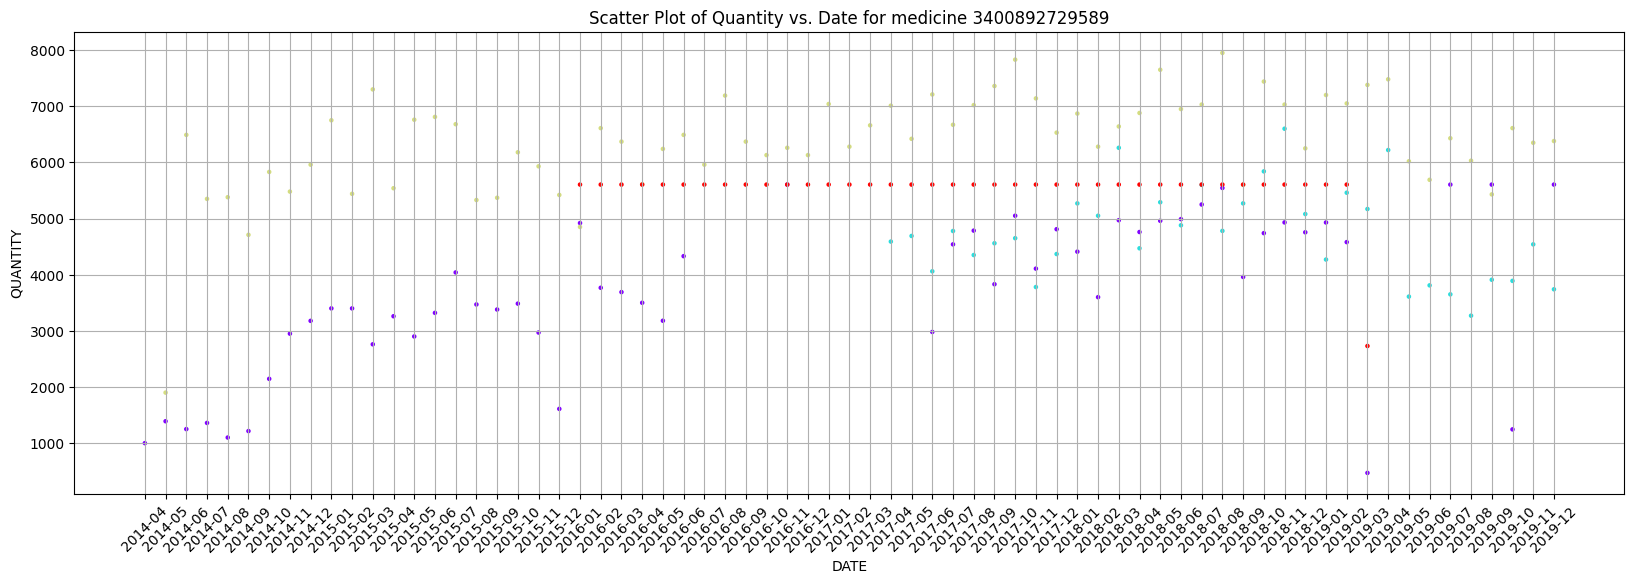

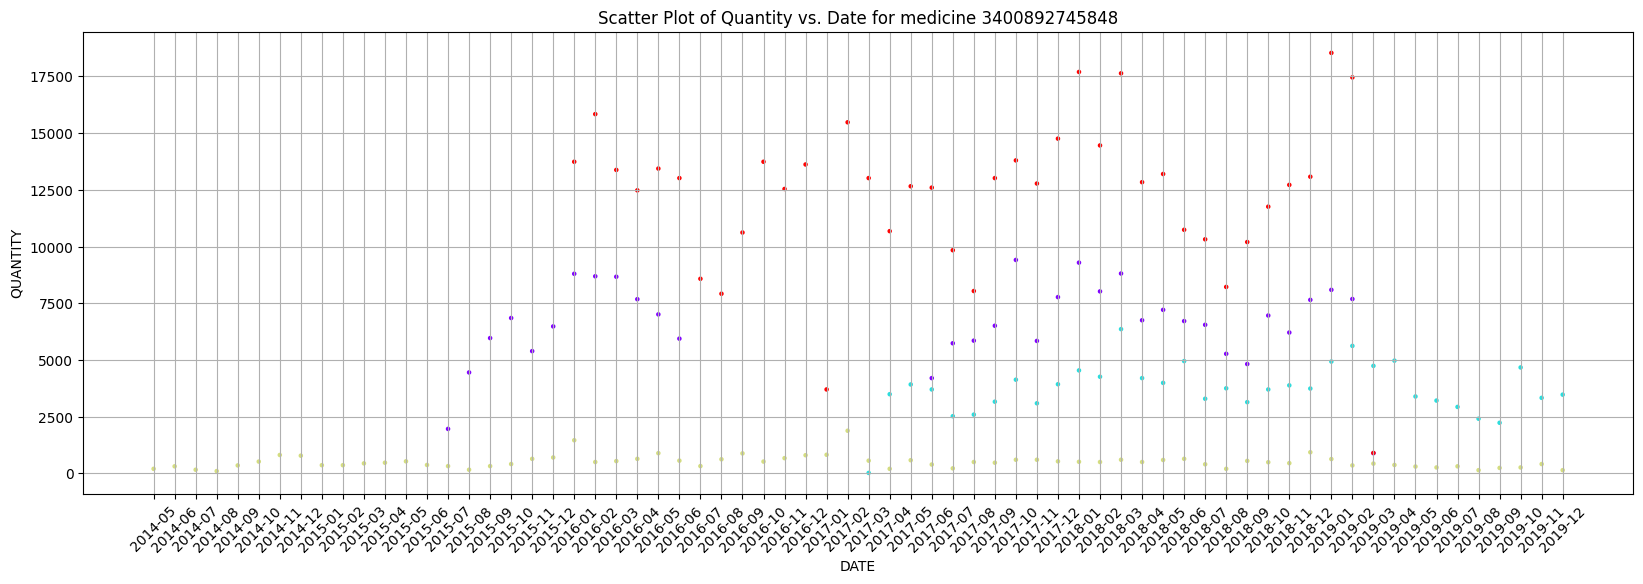

In [65]:
for medicine in df_resampled.HOSPI_CODE_UCD.unique():
  x = df_resampled[df_resampled["HOSPI_CODE_UCD"] == medicine]["DATE"].copy()
  y = df_resampled[df_resampled["HOSPI_CODE_UCD"] == medicine]["QUANTITY"].copy()

  plt.figure(figsize=(20, 6))  # Set the figure size

  plt.scatter(x, y,
              c = df_resampled[df_resampled["HOSPI_CODE_UCD"] == medicine]["ID_SITE_RATTACHE"].copy(),
              s=5, cmap='rainbow')  # Use color argument to assign different colors to each series

  plt.xticks(rotation=45)  # Rotate x-axis tick labels by 45 degrees

  plt.xlabel('DATE')  # Set x-axis label
  plt.ylabel('QUANTITY')  # Set y-axis label

  plt.title(f'Scatter Plot of Quantity vs. Date for medicine {medicine}')  # Set the title of the plot

  plt.grid(True)  # Display grid lines

  plt.show()  # Display the plot


## 2.7 - Transform categorical features

In [68]:
df_resampled_numerical_only = df_resampled.drop(['DATE', 'ID_SITE_RATTACHE', 'YEAR', 'CODE_ATC', 'WEEK'], axis=1).copy()
df_resampled_numerical_only

,HOSPI_CODE_UCD,MONTH,QUANTITY,N_UFS,N_ETB,POPULATION,P_MEDICAL,PN_MEDICAL,LIT_HC,LIT_HP,SEJ_MCO,SEJ_HAD,SEJ_PSY,SEJ_SSR,SEJ_SLD
0,3400891191226,6.0,10.0,1.0,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0
1,3400891225037,6.0,20.0,1.0,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0
2,3400891996128,6.0,110.0,1.0,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0
3,3400892065366,6.0,30.0,1.0,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0
4,3400892075761,6.0,2955.0,1.0,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4069,3400893736135,12.0,4750.0,6.0,50.0,1171739.0,1318.0,7578.0,2011.0,529.0,116793.0,1099.0,2297.0,1169.0,124.0
4070,3400893826706,12.0,2121.0,6.0,5.0,542302.0,706.0,5013.0,1141.0,141.0,76593.0,0.0,1007.0,206.0,0.0
4071,3400893826706,12.0,9070.0,7.5,50.0,1171739.0,1318.0,7578.0,2011.0,529.0,116793.0,1099.0,2297.0,1169.0,124.0
4072,3400893875490,12.0,7920.0,12.0,5.0,542302.0,706.0,5013.0,1141.0,141.0,76593.0,0.0,1007.0,206.0,0.0


In [69]:
df_resampled_numerical_only.to_csv('df_resampled.csv', index=False)